In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json


In [2]:
#raw data from
#https://www.leefilters.com/scripts/data/chart-pdf-data.js
rawdata = json.load(open('filters2.json','rb'))

data = {}
for d in rawdata:
    if 'data' in rawdata[d]:
        if len(rawdata[d]['data'])==61:
            data[d] = rawdata[d]['data']
            
lam = np.arange(400,700.1,5) #400-700 steps of 5

In [3]:
ir_cut = np.ones(len(lam))
ir_cut[lam>660]=0
approx_spread = np.exp(-(lam-600)**2/250**2)
sensors = []
for col in ['blue','green','red']: 
    df = pd.read_csv('%s.csv' % col,names=['wavelength','percent']) #in nm
    #plt.plot(df['wavelength'],df['percent'],label=col,c=col)
    spec = np.interp(lam, df['wavelength'], df['percent'])
    #spec = spec*ir_cut
    #spec = spec*approx_spread
    spec = spec / np.sum(spec) #normalised.
    
    sensors.append(spec)
#plt.legend()

datasheets...

https://dvd.ilphotonics.com/Smartek%20Vision%20-%20GigE%20&%20USB3%20cameras%20-%20pulsed%20LED%20drivers/Cameras/SMARTEKvision_twentynine_UserManual_v1-1-0.pdf



In [4]:
initialspectrum = np.ones(len(lam))
expected = {}
for filterid in data:
    spectrum = initialspectrum.copy()
    spectrum = spectrum * (np.array(data[filterid])/100) 
    spectrum = spectrum * (np.array(data[filterid])/100) #passes through twice
    #spectrum = spectrum * approx_spread
    spectrum 
    resp = []
    for sens in sensors:
        resp.append(np.sum(sens * spectrum))
    if filterid.isdecimal():
        expected[filterid] = resp
    #print(np.mean(resp))

In [5]:
expected

{'002': [0.38586383824194626, 0.22127574555353352, 0.5976686328277527],
 '003': [0.6704940620070933, 0.5992423889896641, 0.6596512241359753],
 '004': [0.26189784703861013, 0.38542294860645804, 0.7202714717568258],
 '007': [0.4331705974794499, 0.7060795920993905, 0.7742403315362241],
 '008': [0.07368008324581622, 0.18534915956361975, 0.6051635915624485],
 '009': [0.24605712092359835, 0.4712019047812164, 0.7257705195866481],
 '010': [0.18388593743339404, 0.6371781246767553, 0.7763140446453091],
 '013': [0.19025026377998103, 0.45990338457139246, 0.7254599631463248],
 '015': [0.0808617673967036, 0.35096477720223457, 0.7177888377521697],
 '017': [0.01841107263106544, 0.04008187219277597, 0.10786688277517734],
 '019': [0.051156834854986975, 0.12650085446822582, 0.507070673667799],
 '020': [0.07416040767671134, 0.25912838063508975, 0.6320019391526401],
 '021': [0.05806056800651114, 0.1750125324722828, 0.5847708506345309],
 '022': [0.05256663144778724, 0.1436668791638689, 0.5369845011592222],


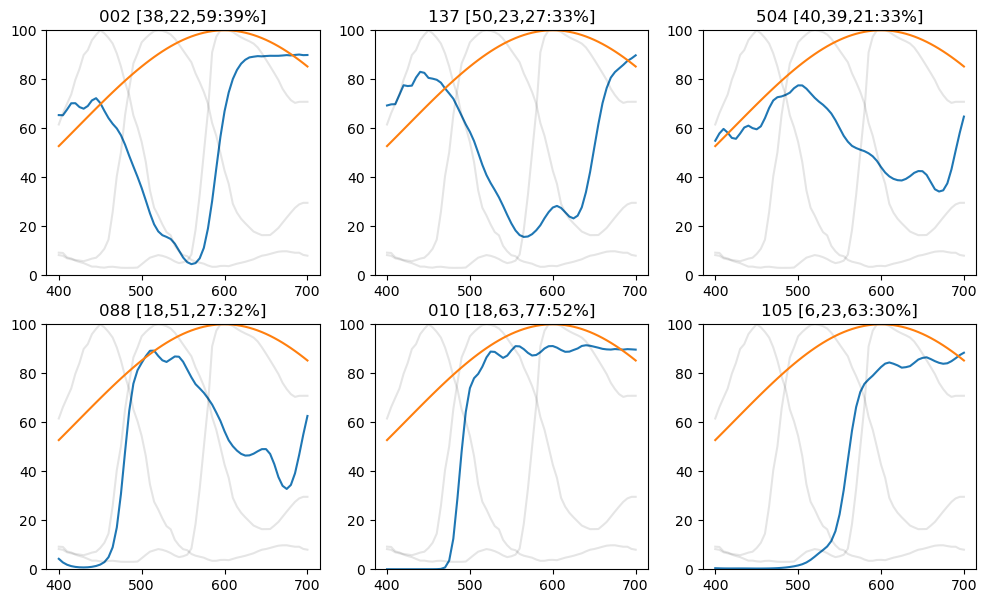

In [6]:
#plt.figure(figsize=[50,120])
plt.figure(figsize=[12,7])
#for i,d in enumerate(data):
for i,d in enumerate(['002','137','504','088','010','105']):
    #plt.subplot(35,10,i+1)
    if i+1>6: break
    plt.subplot(2,3,i+1)
    
    plt.plot(lam,data[d])
    for sens in sensors:
        plt.plot(lam,sens*100/np.max(sens),'k-',alpha=0.1)
    plt.plot(lam,approx_spread*100)
    plt.ylim([0,100])
    resp = (np.array(expected[d])*100).astype(int)
    
    plt.title("%s [%d,%d,%d:%d%%]"%(d,resp[0],resp[1],resp[2],np.sum(resp)/3))

In [7]:
exps = []
for ex in expected:
    exps.append(np.array(expected[ex]))
exps = np.array(exps)

signal = np.mean(exps,1)

sigkeep = signal > 0.5 #0.4 #0.2
exps = exps/np.sum(exps,1)[:,None]

allexps = exps.copy()
exps = exps[sigkeep]


In [8]:
dist = np.zeros([len(exps),len(exps)])
for i in range(3):
    dist+=(exps[:,i:(i+1)].T-exps[:,i:(i+1)])**2
dist = np.sqrt(dist)
dist_notfilled = dist.copy()
np.fill_diagonal(dist,100)

In [9]:
print("%d colour initially, %d above threshold." % (len(sigkeep),len(exps)))

271 colour initially, 38 above threshold.


In [10]:
K = 6  #number to select

def fn(a):
    return np.min(a) #a**0.1 #np.sqrt(a) #np.log(1e-4+a) #np.sqrt(a)#-1/np.sqrt(a)

subsamp = list(np.random.choice(len(dist),K,replace=False))
bestsubsamp = subsamp.copy()
bestscore = -np.inf
for it in range(20):
    if it%2000==0: subsamp = list(np.random.choice(len(dist),K,replace=False)) #random restarts.
    minpair = np.unravel_index((dist[subsamp,:][:,subsamp]+0.2*np.random.randn(K,K)).argmin(), dist[subsamp,:][:,subsamp].shape)
    #if np.sum(fn(dist_notfilled[subsamp[minpair[0]],:]))<np.sum(fn(dist_notfilled[subsamp[minpair[1]],:])):
    if np.sum(fn(dist[subsamp[minpair[0]],:]))<np.sum(fn(dist[subsamp[minpair[1]],:])):
        use = subsamp[minpair[0]]
    else:
        use = subsamp[minpair[1]]
    subsamp.remove(use)
    while True:
        add = np.random.choice(len(dist),1,replace=False)
        if add not in subsamp: 
            if np.sum(fn(dist[add,subsamp]))>np.sum(fn(dist[use,subsamp])):
            #if np.sum(fn(dist_notfilled[add,subsamp]))>np.sum(fn(dist_notfilled[use,subsamp])):
                break
            if np.random.rand()<0.02: #need to stop eventually.
                break
    subsamp.append(add[0])    
    score = np.nansum(fn(dist[subsamp,:][:,subsamp]))
    if score>bestscore:
        bestscore = score
        bestsubsamp = subsamp.copy()
    if it%1000==0: print(score,bestscore)
        
subsamp = bestsubsamp

0.015394877505654542 0.015394877505654542


In [11]:
subsamp = bestsubsamp
keep = subsamp

In [12]:
keep

[28, 33, 19, 8, 14, 21]

In [13]:
sigkeep

array([False,  True, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False,  True,
        True,  True, False,  True, False, False, False, False, False,
       False, False,

In [ ]:
['002','137','504','088','010','105']

In [21]:
import matplotlib.pyplot as plt
import ternary
import math

def color_point(x, y, z, scale):
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 1.)

def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d

#keep = np.mean(exps,1)>0.4
scale = 30
data = generate_heatmap_data(scale)
plt.figure(figsize=[30,30])
ax = plt.gca()
figure, tax = ternary.figure(ax,scale=scale)


tax.scatter(np.array([[0.99,0,0]])*scale,marker='D', color='blue',zorder=3)
tax.scatter(np.array([[0,0.99,0]])*scale,marker='D', color='green',zorder=3)
tax.scatter(np.array([[0,0,0.99]])*scale,marker='D', color='red',zorder=3)
tax.scatter(allexps*scale,marker='o', color='#444f', label="Green Diamonds",zorder=3)#np.array(expected['002']))
for a,b in zip(np.array([e for e in expected]),allexps):
#for a,b in zip(np.array([e for e in expected])[sigkeep],exps):
    if a in ['010','152','248','203','213','007']:
        tax.annotate(a,b*scale,color='white')
        tax.scatter(b[None,:]*scale,marker='x', color='#fff',zorder=3)


#tax.scatter(exps*scale,marker='.', color='#aaa8', label="Green Diamonds",zorder=3)#np.array(expected['002']))
#tax.scatter(exps*scale,marker='x', color='#fff', label="Green Diamonds",zorder=3)#np.array(expected['002']))
tax._redraw_labels()
tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
tax._redraw_labels()
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.boundary()
tax.set_title("RGBA Heatmap")
#print(len(np.array([e for e in expected])[sigkeep][keep]),len(exps[keep,:]))
for a,b in zip(np.array([e for e in expected])[sigkeep][keep],exps[keep,:]):
    pass
    #print(a,b)
    #ax.text((b[0]+b[1])*scale,(b[1])*scale,a,color='white')
    
        #tax.annotate(a,b*scale,color='white')
    #ax.plot(scale*(b[0]+b[1])*np.sqrt(0.5),scale*b[1],'w+')
    
#for a,b in zip(np.array([e for e in expected]),allexps):
#   tax.annotate(a,b*scale,color='white')
plt.show()


ModuleNotFoundError: No module named 'ternary.helpers'; 'ternary' is not a package

Silwood park experiment

| num | name |       page |
| --- | --- | --- |
| 010 | medium yellow | 141 |
| 007 | pale yellow | 136 |
| 213 | white flame green | 98 |
| 203 | 1/4 CT blue | 57 |
| 248 | minus green | 210 |
| 152 | pale gold | 123 |

010


In [37]:
", ".join(sorted(list(np.array([e for e in expected])[sigkeep][keep])))

'010, 152, 203, 213, 247, 279'

| num | name |       page |
| --- | --- | --- |
| 002 | rose pink | 200 |
| 100 | spring yellow | 140 |
| 117 | steel blue | 78 |
| 444 | 1/8 CT straw | 218 |
| 730 | liberty green | 95 |
| ~~773~~ 285 | 3/4 CT Orange | 157 |

In [1]:
['002','137','504','088','010','105']

['002', '137', '117', '088', '010', '105']

New Version:

| num | name |       page |
| --- | --- | --- |
| 002 | rose pink | 200 |
| 137 | special lavender | 13 |
| ~~117~~504 | ~~steel blue~~waterfront green | ~~78~~94 |
| 088 | lime green | 105 |
| 010 | medium yellow | 141 |
| 105 | orange | 150 |

In [220]:
e = '002'
e.isdecimal() 

True

In [222]:
[e for e in expected if e.isdecimal()]

['002',
 '003',
 '004',
 '007',
 '008',
 '009',
 '010',
 '013',
 '015',
 '017',
 '019',
 '020',
 '021',
 '022',
 '024',
 '025',
 '026',
 '027',
 '029',
 '035',
 '036',
 '046',
 '048',
 '049',
 '052',
 '053',
 '058',
 '061',
 '063',
 '068',
 '071',
 '075',
 '079',
 '085',
 '088',
 '089',
 '090',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '113',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '124',
 '126',
 '127',
 '128',
 '130',
 '131',
 '132',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '147',
 '148',
 '151',
 '152',
 '153',
 '154',
 '156',
 '157',
 '158',
 '159',
 '161',
 '162',
 '164',
 '165',
 '169',
 '170',
 '172',
 '174',
 '176',
 '179',
 '180',
 '181',
 '182',
 '183',
 '192',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '200',
 '201',
 '202',
 '203',
 '204',
 '205',
 '206',
 '207',
 '208',
 '212',
 '213',
 '218',
 '219',
 '223',
 '230',
 '232',
 '236',
 '237',


In [221]:
[e.isdecimal() for e in expected]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,